In [1]:
# This script was written using Python 3.7

import pandas as pd # written using v. 0.24.2
import numpy as np # written using v. 1.16.2
import math # written using v. 1.1.0
import matplotlib.pyplot as plt # written using v. 3.1.1
import scipy.stats as ss # written using v. 1.3.2
import cmocean # written using v. 2.0

# for maps, import...
import cartopy as cp
import cartopy.crs as ccrs # CRS holds the various projections
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io import shapereader

# to read netCDF data, import...
import netCDF4 as nc
from netCDF4 import Dataset as NetCDFFile

## Script summary
This script: 

1) imports predicted NFR

2) creates a map of predicted sea surface NFR overlain by measured rates

3) creates profiles of predicted NFR overlain by measured NFR and hydrographic properties

4) calculates areal NFR from predicted and measured volumetric rates

## 1. Data are imported

In [136]:
# import NFR predicted from CTD data
infile = '../Calculations/RF_CTDPred.csv'
df_ctd = pd.read_csv(infile)

# organize df by date for later trapezoidal depth-integration 
df_ctd = df_ctd.sort_values(by = ['Sta','Depth_m'])

df_ctd.columns

Index(['Unnamed: 0', 'Lat', 'Lon', 'Sta', 'Depth_m', 'SeafloorDepth_m',
       'Temp_C', 'Sal', 'Chl_mgm3', 'NFR_log10nmolNLd'],
      dtype='object')

In [3]:
# import NFR predicted from satellite data
infile = '../Calculations/RF_SatPred.csv'
df_sat = pd.read_csv(infile)
df_sat.columns

Index(['Unnamed: 0', 'Lat', 'Lon', 'SeafloorDepth_m', 'Temp_C', 'Chl_mgm3',
       'NFR_log10nmolNLd'],
      dtype='object')

In [19]:
# import file with NFR and corresponding hydrographic information
# see Sharp16_15N2tracer_allrates_hydrograph_ReadMe.csv for full file description

infile = '..\Calculations\Sharp16_15N2tracer_compiledrates_hydrograph.csv' # This file contains mean rates
df = pd.read_csv(infile)

# IrregInc_flag = Irregular incubation flag
#     - 0 = incubation is normal
#     - 1 = incubation conditions were manipulated (e.g., incubation was artificially dark, C was added,, or inc was 12 
#           instead of 24 hours)

# exclude rows where the incubation conditions were manipulated (i.e., did not represent the environment)
df = df[(df.IrregInc_flag == 0)]

# create new spreadsheet for plotting

# drop nans from relevant rows
df = df.drop(['UniqID', 'LocID', 'IrregInc_flag', 'IncLength_h',
       'IncVol_L', 'GlucoseAdd_ul', 'PCconc_uM', 'PCconc_err', 'PNconc_uM',
       'PNconc_err', 'FC_d', 'FC_err', 'FC_LOD', 'FC_LOD_err', 
       'NFR_LOD_err', 'SeaFloor_Depth_m', 
       'Press_db', 'Sigmat_kgm3', 'Temp_C', 'Sal', 'DO_umolkg', 'Fluor_mgm3',
       'PO4_uM', 'PO4_err', 'NO2_uM', 'NO2_err', 'NO3_uM', 'NO3_err', 'NH4_nM',
       'NH4_err'], axis = 1).dropna()

# organize df by date for later trapezoidal depth-integration 
df = df.sort_values(by = ['Sta','Depth_m'])

# define target variable
y = df.NFR_nmolNLd
y_err = df.NFR_err

# target data are log-transformed
logy = []
for i in y:
    if i == 0:
        logyi = np.log10(np.median(df.NFR_LOD)) # if Nfix was not detectable, use median LOD instead of value
    else:
        logyi = np.log10(i)
    logy.append('%f' % logyi)
y = logy

# target error are log-transformed
logy = []
for i in y_err:
    if i == 0:
        logyi = 0
    else:
        logyi = np.log10(i)
    logy.append('%f' % logyi)
y_err = logy

# target data are converted back to pd df
dfnew = pd.DataFrame(data = {'nfr': y, 'err': y_err, 'sta': df.Sta, 'z': df.Depth_m, 'lat': df.Lat, 'lon': df.Lon}, dtype = float)
dfnew.head()

,nfr,err,sta,z,lat,lon
0,0.744372,0.142786,1.0,0.93,37.664668,-73.995213
1,-0.272853,0.000000,1.0,35.37,37.664647,-73.995540
2,-0.272853,0.000000,1.0,49.02,37.666807,-73.998360
3,-0.272853,0.000000,3.0,1.90,37.660383,-74.782307
4,-0.272853,0.000000,3.0,9.01,37.663420,-74.782820


In [5]:
# READ IN HIGH-RES COASTLINE FROM GSHHS (l1)
shp = shapereader.Reader('C:/Users/corda/Dropbox/Resources/Shoreline/GSHHS_shp/h/GSHHS_h_L1.shp')# read in bathymetry file (netCDF)

# read in bathymetry file (netCDF)
# BATHYMETRY CITATION:
# Amante, C. and B.W. Eakins, 2009. ETOPO1 1 Arc-Minute Global Relief Model: Procedures, Data Sources and Analysis. 
# NOAA Technical Memorandum NESDIS NGDC-24. National Geophysical Data Center, NOAA. doi:10.7289/V5C8276M [2020-03-19].

# https://maps.ngdc.noaa.gov/viewers/wcs-client/

infile = 'C:/Users/corda/Dropbox/Resources/etopo1_bedrock_eastNAmericanshelf_20200119.nc'
bathy_df = nc.Dataset(infile)
blat = bathy_df.variables['lat'][:]
blon = bathy_df.variables['lon'][:]
bathy = bathy_df.variables['Band1'][:]

# create an array for bathy data; if you don't do this, you'll get error:  "x and y must be same length"
bx, by = np.meshgrid(blon, blat)

bathy_df.close()

## 2. General figures are made
### 2a. Map of sea surface Nfix

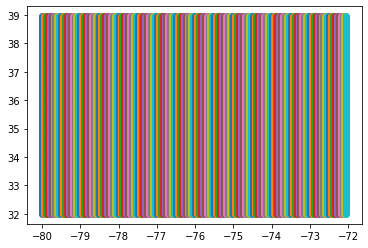

In [6]:
# need to bin the data into a grid to contour it

# make a grid
x = np.arange(-80, -72, .05)
y = np.arange(32, 39, .05)

xx, yy = np.meshgrid(x, y)

h = plt.plot(xx, yy, 'o')
plt.show()

In [7]:
# bin the data into the grid
binned = ss.binned_statistic_2d(df_sat.Lon, df_sat.Lat, df_sat.NFR_log10nmolNLd, statistic='mean', bins=[x, y])
print("min: %f" % np.nanmin(binned.statistic.T))
print("max: %f" % np.nanmax(binned.statistic.T))

min: -0.208422
max: 2.331459


In [8]:
# to do a contour plot, you need to reference the center of the bins, not the edges
# get the bin centers
xc = (x[:-1] + x[1:]) / 2
yc = (y[:-1] + y[1:]) / 2

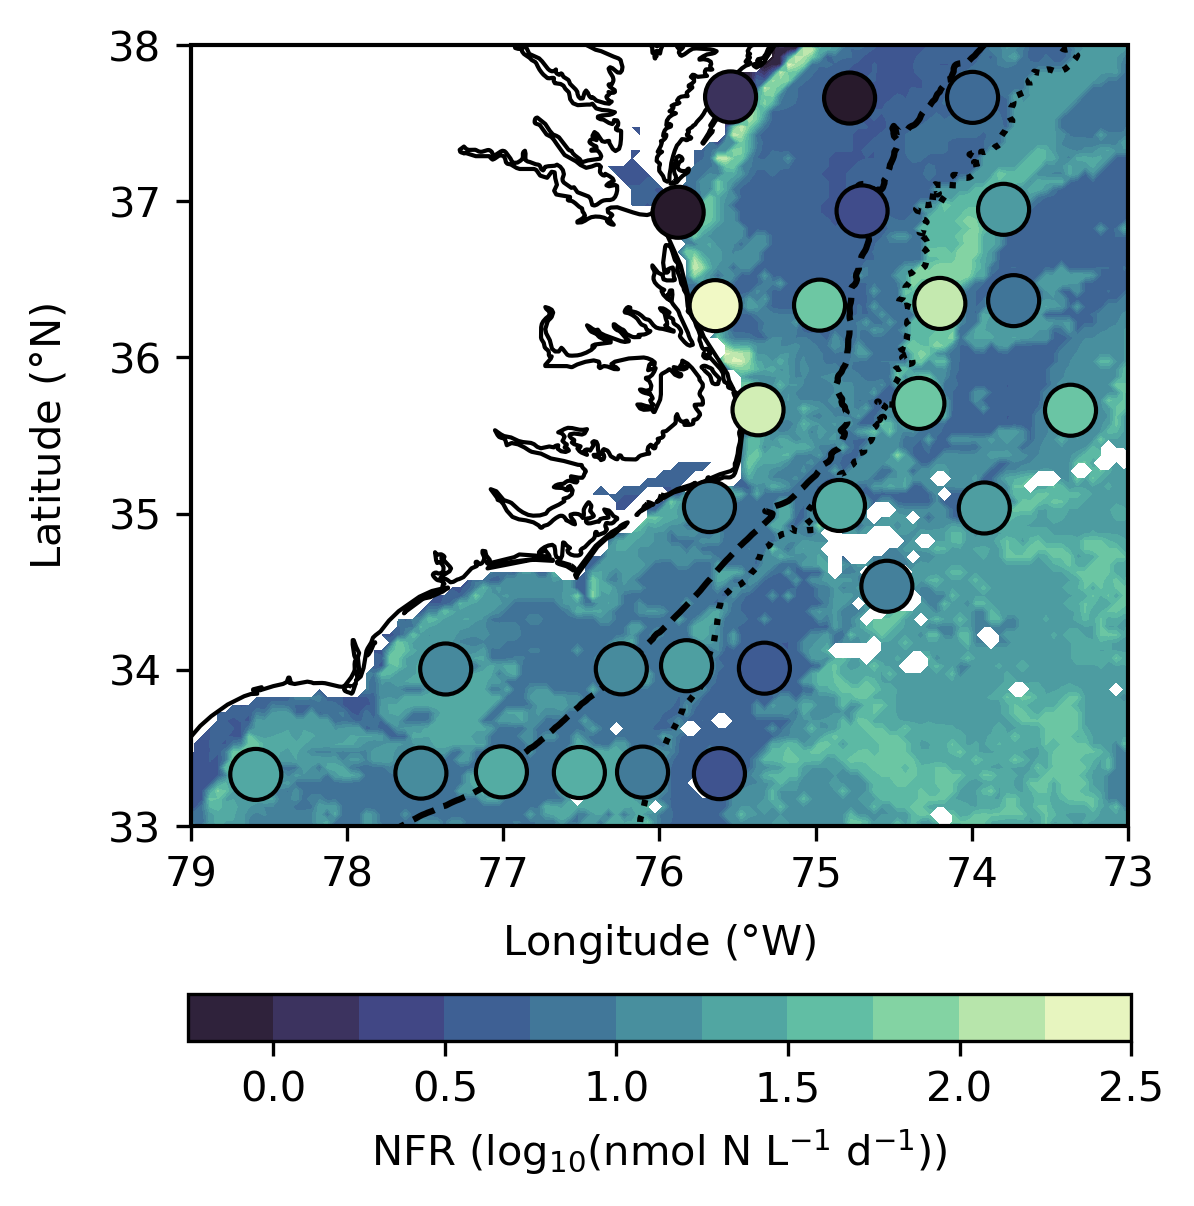

In [9]:
########### PLOT SET-UP ##########################################
fig, ax = plt.subplots(1,1,subplot_kw=dict(projection=ccrs.PlateCarree()),figsize = (4.25,4), dpi = 300)

plt.text(-0.15, 0.5, 'Latitude ($\degree$N)', va = 'center', ha = 'center', transform = ax.transAxes, rotation = -270)
ax.text(0.5, -0.15, 'Longitude ($\degree$W)', va = 'center', ha = 'center', transform = ax.transAxes)

plt.ylim([33,38])
ax.set_yticks(np.arange(33,39,1))

ax.set_xlim([-79,-73])
ax.set_xticks(np.arange(-79,-72,1))
ax.set_xticklabels([79,78,77,76,75,74,73])

# ########## COASTLINES ##############################################
# # HIGH-RES COASTLINE # TURN THIS ON!!!!!
# ax.add_geometries(shp.geometries(),ccrs.PlateCarree(), facecolor='lightgrey', edgecolor='black', linewidth = 0.75, zorder = 0)

# # ALTERNATE LOW-RES COASTLINE
# ax.add_feature(cp.feature.LAND, facecolor = 'lightgrey', zorder = 0) # this is cruder even than the coastline
ax.coastlines(resolution = '10m', zorder = 0) # this uses the preloaded coastlines
# ax1.coastlines(resolution = '10m', zorder = 0) # this uses the preloaded coastlines

# ########### AX DATA ################################################

palette = 'cmo.deep_r'

CS = ax.contourf(xc, yc, binned.statistic.T, vmin = -0.25, vmax = 2.5, levels = 20, cmap = palette, zorder = -1)

m = plt.cm.ScalarMappable(cmap=palette)
m.set_array(binned.statistic.T)
m.set_clim(-0.25, 2.5)
cb = plt.colorbar(m, boundaries=np.linspace(-0.25, 2.5, 12), ax = ax, orientation = "horizontal")
cb.set_label('NFR (log$_{10}$(nmol N L$^{-1}$ d$^{-1}$))')

ax.scatter(dfnew.lon[dfnew.z < 5],dfnew.lat[dfnew.z < 5], c = dfnew.nfr[dfnew.z < 5], s = 150, cmap = palette, vmin = -0.25, vmax = 2.5, edgecolors = 'k', zorder = 102)

ax.contour(bx, by, bathy, [-200], colors = 'black', transform = ccrs.PlateCarree(), linewidths = 1.5, linestyles = '--')
ax.contour(bx, by, bathy, [-2000], colors = 'black', transform = ccrs.PlateCarree(), linewidths = 1.5, linestyles = ':')

########### ADJUST FINAL LAYOUT #############################################
plt.subplots_adjust(wspace = 0.1)

plt.gcf().subplots_adjust(left = 0.16, right = 0.90, bottom = 0.02, top = 0.95)

######### SAVE FIGURE #################################
# As a .png file:
plt.savefig("..\Figures\Sharp16_RF_satpred.png") 

# # Or as a .tiff file:

# # Save the image in memory in PNG format using pillow
# png1 = io.BytesIO()
# fig.savefig(png1, format="png")

# # Load this image into PIL
# png2 = Image.open(png1)

# # Save as TIFF
# # figname = "..\Figures\Sharp16_Fig_hydrography_2panel"
# png2.save("..\Figures\Sharp16_Fig_hydrography_2panel_nostalabels.tiff")
# png1.close()

### 2b. NFR profiles for each station

In [11]:
listit = df_ctd.Sta.unique()

for a in listit: # station ID list
    
    if np.max(df_ctd.Depth_m[df_ctd.Sta == a]) < 250:
        maxdepth = np.max(df_ctd.Depth_m[df_ctd.Sta == a]) + 1
    else:
        maxdepth = 250 # MOST MEASUREMENTS ABOVE 150; very few measurements made below 250 m
    
    # create plot
    fig, ax = plt.subplots(1,1, dpi = 300, figsize = (4,5))

    # set up plot
    ax.set_ylim(0,maxdepth) 
    ax.set_ylabel('Depth (m)')
    plt.gca().invert_yaxis()
    plt.title('Station %i' % a)
    
    ax1 = ax.twiny()
    ax2 = ax1.twiny()
    
    # plot chlorophyll on ax
    p, = ax.plot(df_ctd.Chl_mgm3[df_ctd.Sta == a] - 0.4,df_ctd.Depth_m[df_ctd.Sta == a], color = 'g', label = '[Chl-a]', alpha = 0.75)
    ax.set_xlabel('[Chl-a] ($\mu$g L$^{-1}$)')
    ax.set_xticks(np.arange(0,6,1))
    ax.set_xticks(np.arange(0,6,0.5), minor = True)
    ax.set_xlim(0,4)

    # plot temp on ax1
    p1, = ax1.plot(df_ctd.Temp_C[df_ctd.Sta == a], df_ctd.Depth_m[df_ctd.Sta == a], color = 'b', alpha = 0.75, label = 'Temp')
    ax1.set_xlabel('Temperature ($\degree$C)', labelpad = -290)
    ax1.spines["bottom"].set_position(("axes", -0.2))
    ax1.set_xticks(np.arange(10,40,5))
    ax1.set_xticks(np.arange(10,40,2.5), minor = True)
    ax1.set_xlim(10,30)

    # plot NFR on ax2
    p2, = ax2.plot(df_ctd.NFR_log10nmolNLd[df_ctd.Sta == a], df_ctd.Depth_m[df_ctd.Sta == a], '-ok', label = 'Pred NFR', zorder = 1, mfc = 'w')
    p3, = ax2.plot(dfnew.nfr[df.Sta == a], dfnew.z[df.Sta == a], 'ro', label = 'Meas NFR', markeredgecolor = 'k', markersize = 8)
    ax2.errorbar(dfnew.nfr[df.Sta == a], dfnew.z[df.Sta == a], xerr = dfnew.err[df.Sta == a], fmt = 'o', c = 'r', ecolor = 'k', mec = 'k', markersize = 8, capsize = 2, zorder = 2)

    p4, = ax2.plot(np.ones(50,)*np.log10(np.median(df.NFR_LOD)),np.arange(0,500,10), color = 'k', linewidth = 4, linestyle = '--', label = 'Med DL', zorder = -1, alpha = 0.5)
    p5, = ax2.plot(np.ones(50,)*np.log10(1),np.arange(0,500,10), 'b', linewidth = 4, linestyle = '--', label = 'Nom DL', zorder = -1, color = 'k', alpha = 0.25)

    ax2.set_xlabel('NFR (log$_{10}$(nmol N L$^{-1}$ d$^{-1}$))')
    ax2.set_xlim(-1,3)

    # create figure legend
    lines = [p,p1,p2,p3,p4,p5]
    ax2.legend(lines, [l.get_label() for l in lines], loc = 'lower right')

    # adjust final layout
    plt.gcf().subplots_adjust(left = 0.19, bottom = 0.25, top = 0.85, right = 0.92)

    # save fig   
    filename = "..\Figures\Profiles\Sharp16_RF_Station%i.png" % a
    plt.savefig(filename) 
    plt.close() # turn off to test
    
    plt.show()

## 3. Areal rates are caculated from predicted and measured rates via trapezoidal depth-integration

Calculation notes:

- the np.trapz function only integrates through the range of x i.e. depth (integrated rate defined here as "trapint")
- because the first depth increment is often 2 m in binned CTD profiles (from which NFR are predicted), we assume that the shallowest predicted rate was constant through the surface, extending our depth-integration to 0 m depth (here, "topint")
- because the ctd casts do not extend all the way to the seafloor, when bottomdepth (greatest depth to which NFR is integrated--either the seafloor depth or the maxdepth set, whichever is shallower) < maxdepth (maximum potential integration depth), we depth-integrate from the deepest measurement to bottomdepth assuming that NFR is 0 at bottomdepth EXCEPT at very shallow stations (<50 m) where we assume that NFR at bottomdepth = NFR at the deepest sampled point (here, "bottomint")
- these assumptions are based on observations (NFR tends to decrease with depth except at very shallow stations where the water column is well-mixed and NFR tend to be consistent throughout the water column)
- 150 m is used as the maxdepth because relatively few measurements were made below this; it corresponds somewhat to typical euphotic depth, however, not all diazotrophs present are photosynthetic
- measured NFR were only propagated if at least 2 depths were surveyed above maxdepth

In [192]:
# set the maximum depth for integration
maxdepth = 100 # maximum depth for integration

In [193]:
# trapezoidally depth-integrate nfr 

listit = df_ctd.Sta.unique() # station ID list
sta = [] # create object to populate with sta IDs
zint = [] # create object to populate with calculated depth-int rates based on predicted nfr

for a in listit:

    # set the bottom depth to which to integrate; either station depth or maxdepth is used, whichever is shallower
    if np.mean(-df_ctd.SeafloorDepth_m[df_ctd.Sta == a]) < maxdepth: # note: seafloor_depth is a negative value in this spreadsheet
        bottomdepth = np.mean(-df_ctd.SeafloorDepth_m[df_ctd.Sta == a]) 
    else:
        bottomdepth = maxdepth

    # set x and y for trapezoidal integration 
    y = 10**df_ctd.NFR_log10nmolNLd[(df_ctd.Sta == a) & (df_ctd.Depth_m <= bottomdepth)] # convert log(NFR) to NFR (nmol N L-1 d-1)
    x = df_ctd.Depth_m[(df_ctd.Sta == a) & (df_ctd.Depth_m <= bottomdepth)] # units: m

    trap = []
    for i in y:
        if i < 1:
            ytrapi = 0 # if predicted nfr is < "nominal" detection limit (1 nmol N L-1 d-1), assume it is zero to avoid overestimation
        else:
            ytrapi = i
        trap.append(ytrapi)
    trap = pd.DataFrame({'y':trap,'x':x}, dtype = float)

    # perform trapezoidal depth-integration
    midint = np.trapz(trap.y, x=trap.x) # unit conversion: nmol N L-1 d-1 * m * (1000 L m-3) * (0.001 umol nmol-1) = umol N m-2 d-1

    # integrate through the surface layer, assuming constant Nfix rate, using shallowest prediction 
    topint = trap.y[trap.x == np.min(trap.x)] * np.min(trap.x)

    # if the ctd did not extend to the bottomdepth, integrate the deepest rate as follows:
    if bottomdepth < maxdepth:
        # define the deepest rate measurement above bottomdepth
        x1 = np.max(x[(trap.x < bottomdepth)])
        y1 = trap.y[trap.x == x1].item()
        # if the station was shallow, integrate the deepest rate to the bottomdepth
        if np.mean(-df_ctd.SeafloorDepth_m[df_ctd.Sta == a]) < 50:
            bottomint = (bottomdepth - x1)*y1
        # if the station was not shallow, assume the NFR went to 0 at the bottom depth
        else:
            bottomint = (bottomdepth - x1)*y1/2
    else:
        bottomint = 0

    # total areal NFR is the sum depth-integrated rate
    depthintnfr = midint + topint + bottomint
    
    # save calculation
    sta.append("%i" % a)
    zint.append("%f" % depthintnfr)
    
pred_zint_df = pd.DataFrame({"sta": sta,"pred": zint}, dtype = float)
pred_zint_df.head()

,sta,pred
0,1.0,292.372847
1,2.0,232.216443
2,3.0,168.508659
3,4.0,301.807271
4,5.0,0.000000


In [194]:
# trapezoidally depth-integrate measured nfr 
# NOTE:  data must be organized sequentially in df to use np.trapz function correctly (see above)!

listit = df.Sta.unique() # station ID list
sta = [] # create object to populate with sta IDs
zint = [] # create object to populate with calculated depth-int rates based on predicted nfr

for a in listit:

    # set the bottom depth to which to integrate; either station depth or maxdepth is used, whichever is shallower
    if np.mean(-df_ctd.SeafloorDepth_m[df_ctd.Sta == a]) < maxdepth: # note: seafloor_depth is a negative value in this spreadsheet
        bottomdepth = np.mean(-df_ctd.SeafloorDepth_m[df_ctd.Sta == a]) 
    else:
        bottomdepth = maxdepth

    # set x and y for trapezoidal integration 
    y = df.NFR_nmolNLd[(df.Sta == a)]
    x = df.Depth_m[(df.Sta == a)]

    # only calculate depth-integrated rates if there were two or more depths surveyed above maxdepth
    x_above = len(x[x<maxdepth])
    if x_above >= 2:

        # integrate through the surface layer, assuming constant Nfix rate, using shallowest prediction 
        topint = y[x == np.min(x)] * np.min(x)

        # integrate through mid-water column
        midint = np.trapz(y[(df.Depth_m < bottomdepth)], x=x[(df.Depth_m < bottomdepth)])

        # integrate through deepest piece of depth interval
        # if any measurements were made below  the bottom depth, assume NFR decreased linearly to that point
        # define the deepest rate measurement above bottomdepth
        x1 = np.max(x[(df.Depth_m < bottomdepth)])
        y1 = y[x == x1].item()
        if (x > bottomdepth).any() == True: 
            # define the shallowest rate measurement below bottomdepth
            x3 = np.min(x[(df.Depth_m > bottomdepth)])
            y3 = y[x == x3].item()
            # calculate slope and y-int for line between the two points
            m = (y3-y1)/(x3-x1) # slope
            b = y1 - (m*x1) # y-intercept
            # find nfr at bottomdepth
            y2 = m*bottomdepth + b
            # calculate trapezoidal area
            bottomint = (bottomdepth - x1)*(y1 + y2)/2
        else: 
        # if the station was shallow, integrate the deepest rate to the bottomdepth
            if np.mean(-df_ctd.SeafloorDepth_m[df_ctd.Sta == a]) < 50:
                bottomint = (bottomdepth - x1)*y1
        # if the station was not shallow, assume the NFR went to 0 at the bottom depth
            else:
                bottomint = (bottomdepth - x1)*y1/2

        # total areal NFR is the sum depth-integrated rate
        depthintnfr = bottomint + midint + topint

        # save calculation
        sta.append("%i" % a)
        zint.append("%f" % depthintnfr)
    
meas_zint_df = pd.DataFrame({"sta": sta,"meas": zint}, dtype = float)
meas_zint_df.head()

,sta,meas
0,1.0,100.750850
1,3.0,0.000000
2,5.0,5.644679
3,6.0,11.911712
4,8.0,74.014554


In [195]:
# create a file with depth-integrated rates

OutFileName = '../Calculations/Sharp16_DepthIntRates.csv'
OutFile = open(OutFileName, 'w')
OutFile.write("Sta,SeafloorDepth_m,PredNFR_umolNm2d,MeasNFR_umolNm2d\n")

listit = df_ctd.Sta.unique()

for a in listit:
    sfz = np.mean(-df_ctd.SeafloorDepth_m[df_ctd.Sta == a])
    if (meas_zint_df.sta == a).any() == True:
        OutputString = "%i,%.2f,%.2f,%.2f" % (a,sfz,pred_zint_df.pred[pred_zint_df.sta == a],meas_zint_df.meas[meas_zint_df.sta == a])
    else:
        OutputString = "%i,%.2f,%.2f," % (a,sfz,pred_zint_df.pred[pred_zint_df.sta == a])

    OutFile.write(OutputString + "\n")

OutFile.close()

pd.read_csv(OutFileName).head()

,Sta,SeafloorDepth_m,PredNFR_umolNm2d,MeasNFR_umolNm2d
0,1,1260.86,292.37,100.75
1,2,71.66,232.22,NaN
2,3,41.66,168.51,0.00
3,4,24.57,301.81,NaN
4,5,13.56,0.00,5.64
